In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random as random
import numpy as np
import matplotlib.animation as animation

In [2]:
def insert(digit, frame, position):
    for i, line in enumerate(digit):
        for j, pixel in enumerate(line):
            frame_value = frame[position[0]+i, position[1]+j]
            if frame_value + pixel > max_value:
                frame[position[0]+i, position[1]+j] = max_value
                #saturation
            else:
                frame[position[0]+i, position[1]+j] += pixel
    return frame

In [3]:
def create_frame(frame_dimensions, digits, positions):
    frame = np.zeros((frame_dimensions[0], frame_dimensions[1]))
    for k, digit in enumerate(digits):
        position = positions[k]
        frame = insert(digit, frame, position)
    return frame

In [4]:
def mirror_direction(direction, position, frame_size):
    #only called if digit hits a wall, so either x or y equals 0 or frame_size-1
    dx, dy = direction
    x,y = position
    if (x==0 or x==frame_size-1) and y!=0 and y!=frame_size-1:
        dx = -dx
    if (y==0 or y==frame_size-1) and x!=0 and x!=frame_size-1:
        dy = -dy
    if (x==0 or x==frame_size-1) and (y==0 or y==frame_size-1):
        dx, dy = -dx, -dy
    return [dx, dy]

In [5]:
def closest_frontier(position, frame_size):
    x,y = position
    neighbor_frontiers = [(frame_size-1,y), (0,y), (x, frame_size-1), (x,0)]
    distances = []
    distances.append(frame_size - (x+digit_size))
    distances.append(x)
    distances.append(frame_size - (y+digit_size))
    distances.append(y)
    return neighbor_frontiers[distances.index(min(distances))]

In [6]:
def non_null_sample(max_value, number):
    values = list(np.arange(-max_value, max_value+1))
    sample = []
    for i in range(number-1):
        sample.append(random.choice(values))
    #for the last value, we cannot add a zero if there are only zero in the selected values
    if list(set(sample)) != [0]:
        sample.append(random.choice(values))
    else:
        values.remove(0)
        sample.append(random.choice(values))
    return sample

In [7]:
def new_position(position, direction):
    x,y = position
    dx, dy = direction
    return [x+speed*dx, y+speed*dy]

In [8]:
def out_of_frame(position, frame_dimensions):
    for i, dimension in enumerate(position) :

        if dimension + digit_size  > frame_dimensions[i]:
            return True
        if dimension < 0:
            return True
    return False

In [9]:
def in_the_center(position, frame_size):
    security_distance = abs(speed*max_jump)+ digit_size
    for dimension in position :
        if abs(frame_size-dimension)<security_distance or dimension < security_distance:
            return False
    return True

In [10]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [27]:
frame_size = 280
digit_size = len(train_images[0])
n_digits = 5
duration = 100
max_jump = 2 #to define the angles of the direction
max_value = 254
speed = 2

253


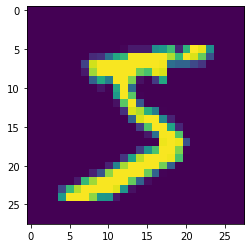

In [28]:
plt.imshow(train_images[0])
#pixel value between 0 and 254
print(train_images[0][7,11])

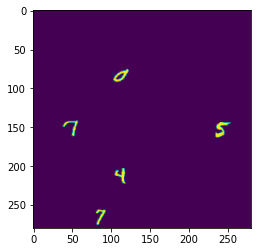

In [29]:
test_indexes = random.sample(range(len(train_images)), n_digits)
test_digits = train_images[test_indexes]
test_labels = train_labels[test_indexes]
#digits and labels are np arrays
#position of each digit, defined as top left corner
test_positions = [random.sample(range(frame_size-digit_size-1),2) for i in range(n_digits)]

test_frame = create_frame((frame_size, frame_size), test_digits, test_positions)

plt.figure()
plt.imshow(test_frame)

In [33]:
frames = []

#Initial conditions

indexes = random.sample(range(len(train_images)), n_digits)
digits = train_images[test_indexes]
labels = train_labels[test_indexes]
                      
positions = [random.sample(range(frame_size-digit_size-1),2) for i in range(n_digits)]

frame = create_frame((frame_size, frame_size), digits, positions)
                      
#the frame with the digits is created
#initial directions of teach digit
#Choice of (2**max_jump) * 4 directions, for the movement to be smooth (not jump too much, choose a max_jump)
#Directions denoted by (dx, dy), dx and dy in [-max_jump, max_jump]
#But we don't want (0,0)
            

directions = [non_null_sample(max_jump, 2) for i in range(n_digits)]

       
for time in range(100):
    for k, digit in enumerate(digits):
        
        #update position based on the previously computed direction
        #depending on new position, update direction
        
        position = new_position(positions[k], directions[k])
        positions[k] = position
        
        
        next_position = new_position(positions[k], directions[k])
        
        if out_of_frame(next_position, [frame_size, frame_size]):
            #also returns True if the position is not out of frame but there is not enough room to put the digit there
            rebound_point = closest_frontier(position, frame_size)
            directions[k] = mirror_direction(directions[k], rebound_point, frame_size)
            
        if in_the_center(positions[k], frame_size):
            #if far enough from the frontiers, probability 1/5 to slightly change direction
            
            random_nb = random.random()
            if random_nb < 0.05:
                directions[k][0] += 1
            elif random_nb >= 0.05 and random_nb < 0.1 :
                directions[k][0] -= 1
            if random_nb >= 0.1 and random_nb < 0.15:
                directions[k][1] += 1
            elif random_nb >= 0.15 and random_nb < 0.2 :
                directions[k][1] -= 1
            
            
    #create the frame with the new positions
    frame = create_frame((frame_size, frame_size), digits, positions)
    frames.append(frame)
    

IndexError: index 280 is out of bounds for axis 1 with size 280

MovieWriter ffmpeg unavailable; using Pillow instead.


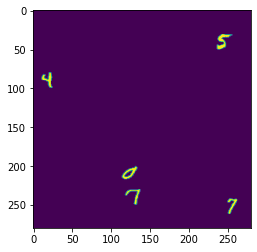

In [32]:
fig, ax  = plt.subplots()
ims = []
for i, image in enumerate(frames):
    im = ax.imshow((image), animated=True)
    if i == 0:
        ax.imshow(image)  # show an initial one first
    ims.append([im])

movie = animation.ArtistAnimation(fig, ims, interval=70, blit=True,
                                repeat_delay=1000)
movie.save('new_movie.gif')